get and format dataset

In [12]:
# load in wine 
import pandas as pd

# Define column names
column_names = [
    "Class", "Alcohol", "Malicacid", "Ash", "Alcalinity_of_ash", "Magnesium",
    "Total_phenols", "Flavanoids", "Nonflavanoid_phenols", "Proanthocyanins",
    "Color_intensity", "Hue", "OD280_OD315_of_diluted_wines", "Proline"
]

# Load the CSV file
df = pd.read_csv("wine/wine.data", names=column_names)

# Display the first few rows
print(df.head())

   Class  Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  \
0      1    14.23       1.71  2.43               15.6        127   
1      1    13.20       1.78  2.14               11.2        100   
2      1    13.16       2.36  2.67               18.6        101   
3      1    14.37       1.95  2.50               16.8        113   
4      1    13.24       2.59  2.87               21.0        118   

   Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color_intensity   Hue  OD280_OD315_of_diluted_wines  Proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05        

In [13]:
# Remove rows where Class is 3
df = df[df["Class"] != 3]

# Display the first few rows to verify
print(df.tail())

     Class  Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  \
125      2    12.07       2.16  2.17               21.0         85   
126      2    12.43       1.53  2.29               21.5         86   
127      2    11.79       2.13  2.78               28.5         92   
128      2    12.37       1.63  2.30               24.5         88   
129      2    12.04       4.30  2.38               22.0         80   

     Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
125           2.60        2.65                  0.37             1.35   
126           2.74        3.15                  0.39             1.77   
127           2.13        2.24                  0.58             1.76   
128           2.22        2.45                  0.40             1.90   
129           2.10        1.75                  0.42             1.35   

     Color_intensity   Hue  OD280_OD315_of_diluted_wines  Proline  
125             2.76  0.86                          3.28      378  
126 

Implement a logistic regression baseline

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [15]:
y = df['Class']
X = df.drop(columns=['Class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
model = LogisticRegression(max_iter=700)
model.fit(X_train, y_train)

/Users/mehul/Documents/Human-AI Research/Coordinate Descent/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=700)

In [17]:
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Logistic Regression Accuracy: {accuracy:.4f}")

Baseline Logistic Regression Accuracy: 1.0000


Now, we specify a custom method of selecting the next coordinate. For this, lets create a function that takes in X and y, and returns an array specifying the order we want to test in. 

Solution idea: Cluster the data by features, and then rotate data points from each cluster. 

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Now we need a custom class so we can directly modify the loss function... 

In [28]:
import numpy as np
from scipy.special import expit
from itertools import product
import multiprocessing
from joblib import Parallel, delayed

class LogisticRegression:
    def __init__(self, lr=0.001, max_iter=2000, tol=1e-4, fit_intercept=True, reg_lambda=0.01):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol  # Tolerance for weight convergence
        self.fit_intercept = fit_intercept
        self.reg_lambda = reg_lambda
        self.weight = None
        self.feature_means = None
        self.feature_stds = None
        self.convergence_window = 10  # Number of iterations to check for weight stability

    def _normalize_features(self, X):
        """Normalizes features using z-score standardization."""
        if self.feature_means is None or self.feature_stds is None:
            self.feature_means = np.mean(X, axis=0)
            self.feature_stds = np.std(X, axis=0) + 1e-8  # Avoid division by zero
        
        return (X - self.feature_means) / self.feature_stds

    def _add_intercept(self, X):
        """Adds intercept term (bias) to feature matrix."""
        return np.c_[np.ones((X.shape[0], 1)), X]

    def _sigmoid(self, z):
        """Sigmoid activation function."""
        # Clip values to prevent overflow
        z = np.clip(z, -20, 20)
        return expit(z)  # Numerically stable sigmoid

    def _compute_loss(self, X, y):
        """Computes the binary cross-entropy loss with regularization."""
        m = len(y)
        h = self._sigmoid(X @ self.weight)
        # Add small epsilon to avoid log(0)
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        
        # Add L2 regularization term (excluding bias)
        reg_term = 0.5 * self.reg_lambda * np.sum(self.weight[1:] ** 2) / m
        
        # Compute binary cross-entropy
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        
        return loss + reg_term
    
    def _compute_gradient_for_coordinate(self, X, y, j, sample_indices=None, sample_weights=None):
        """
        Computes the gradient for a single coordinate j using only the specified samples.
        
        Parameters:
        -----------
        X : array-like
            Feature matrix
        y : array-like
            Target values
        j : int
            Index of the coordinate to compute gradient for
        sample_indices : array-like or None
            Indices of samples to use for gradient computation. If None, use all samples.
        sample_weights : array-like or None
            Weights for each sample. If None, equal weights are used.
        """
        if sample_indices is not None:
            X_batch = X[sample_indices]
            y_batch = y[sample_indices]
            if sample_weights is not None:
                weights_batch = sample_weights[sample_indices]
            else:
                weights_batch = None
        else:
            X_batch = X
            y_batch = y
            weights_batch = sample_weights
        
        m = len(y_batch)
        h = self._sigmoid(X_batch @ self.weight)
        
        if weights_batch is None:
            weights_batch = np.ones(m)
            
        # Gradient for single coordinate using only the batch
        gradient_j = np.sum((h - y_batch) * weights_batch * X_batch[:, j]) / np.sum(weights_batch)
        
        # Add L2 regularization (except for bias term)
        if j > 0 or not self.fit_intercept:
            gradient_j += self.reg_lambda * self.weight[j] / m
            
        return gradient_j
    
    def _custom_gradient_for_coordinate(self, X, y, j, sample_indices=None, sample_weights=None):
        """
        Custom gradient computation for a single coordinate.
        This implements a focal loss variant that puts more emphasis on hard examples.
        
        Parameters:
        -----------
        X : array-like
            Feature matrix
        y : array-like
            Target values
        j : int
            Index of the coordinate to compute gradient for
        sample_indices : array-like or None
            Indices of samples to use for gradient computation
        sample_weights : array-like or None
            Weights for each sample
        """
        if sample_indices is not None:
            X_batch = X[sample_indices]
            y_batch = y[sample_indices]
            if sample_weights is not None:
                weights_batch = sample_weights[sample_indices]
            else:
                weights_batch = None
        else:
            X_batch = X
            y_batch = y
            weights_batch = sample_weights
        
        m = len(y_batch)
        
        # Convert labels from 1/2 to 0/1 for easier calculation
        y_binary = (y_batch == 2).astype(int)
        
        # Get current predictions
        h = self._sigmoid(X_batch @ self.weight)
        
        # Calculate errors with focal loss modulation
        # Focal loss puts more weight on hard examples
        gamma = 2.0  # Focusing parameter
        
        # pt is the probability of the true class
        pt = h * y_binary + (1 - h) * (1 - y_binary)
        # Focal weight is (1-pt)^gamma
        focal_weights = np.power(1 - pt, gamma)
        
        if weights_batch is None:
            weights_batch = np.ones(m)
            
        # Combine focal weights with sample weights
        combined_weights = weights_batch * focal_weights
        
        # Gradient for single coordinate using focal loss
        errors = h - y_binary
        gradient_j = np.sum(errors * combined_weights * X_batch[:, j]) / np.sum(combined_weights)
        
        # Add L2 regularization (except for bias term)
        if j > 0 or not self.fit_intercept:
            gradient_j += self.reg_lambda * self.weight[j] / m
            
        return gradient_j

    def _get_coordinates(self, X, y, n_features, method="random", batch_size=32):
        """
        Determine the coordinates and data points to use for stochastic coordinate descent.
        
        Parameters:
        -----------
        X : array-like
            Feature matrix
        y : array-like
            Target values
        n_features : int
            Number of features
        method : str
            Method to select coordinates ("random", "gradient_based", or "cyclic")
        batch_size : int
            Number of samples to use per update (for mini-batch)
            
        Returns:
        --------
        tuple: (coordinates, batches)
            coordinates: List of feature indices to update
            batches: List of sample indices for each update
        """
        n_samples = X.shape[0]
        
        # Determine coordinates (features) to update
        if method == "random":
            # Randomly select coordinates for each iteration
            coordinates = np.random.randint(0, n_features, size=self.max_iter)
        elif method == "gradient_based":
            # Select coordinates based on gradient magnitude (more informative features)
            # First, calculate full gradient
            # Compute initial gradients for each coordinate
            initial_gradients = np.zeros(n_features)
            for j in range(n_features):
                initial_gradients[j] = abs(self._compute_gradient_for_coordinate(X, y, j))
            
            # Select coordinates proportional to the absolute gradient values
            probs = initial_gradients / np.sum(initial_gradients)
            coordinates = np.random.choice(n_features, size=self.max_iter, p=probs)
        elif method == "cyclic":
            # Cycle through all coordinates repeatedly
            coordinates = np.arange(self.max_iter) % n_features
        else:
            # Default to random if invalid method
            coordinates = np.random.randint(0, n_features, size=self.max_iter)
            
        # Create mini-batches of data points
        # Number of batches needed for max_iter iterations
        n_batches = self.max_iter
        
        # Generate random mini-batch indices for each iteration
        batches = [np.random.choice(n_samples, size=batch_size) for _ in range(n_batches)]
            
        return coordinates, batches

    def _handle_class_imbalance(self, X, y):
        """Calculate class weights for imbalanced datasets."""
        unique_classes = np.unique(y)
        class_weights = {}
        
        for cls in unique_classes:
            class_weights[cls] = len(y) / (len(unique_classes) * np.sum(y == cls))
            
        # Create sample weights array
        sample_weights = np.ones(len(y))
        for cls in unique_classes:
            sample_weights[y == cls] = class_weights[cls]
            
        return sample_weights
    
    def fit(self, X, y, loss_type="baseline", coordinate_choice="random", 
        batch_size=32, handle_imbalance=True, verbose=True):
        """
        Trains the logistic regression model using stochastic gradient descent.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        loss_type : str, default='baseline'
            Loss function type ('baseline' or 'custom')
        coordinate_choice : str, default='random'
            How to choose coordinates for SGD ('random', 'gradient_based', or 'cyclic')
        batch_size : int, default=32
            Number of samples to use in each mini-batch update
        handle_imbalance : bool, default=True
            Whether to weigh samples by inverse class frequency
        verbose : bool, default=True
            Whether to print progress
            
        Returns:
        --------
        accuracies : array-like
            Array of accuracy values during training
        """
        # Convert inputs to numpy arrays
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Normalize features
        X_normalized = self._normalize_features(X)
        
        if self.fit_intercept:
            X_normalized = self._add_intercept(X_normalized)
    
        # Initialize weights with small random values
        np.random.seed(42)  # For reproducibility
        n_features = X_normalized.shape[1]
        self.weight = np.random.randn(n_features) * 0.01
        
        # Handle class imbalance
        if handle_imbalance:
            sample_weights = self._handle_class_imbalance(X, y)
        else:
            sample_weights = np.ones(len(y))
        
        # Store weight history for convergence check
        weight_history = [np.copy(self.weight)]
        converged = False
        
        # Get coordinate order and data batches
        coordinates, batches = self._get_coordinates(
            X_normalized, y, n_features, method=coordinate_choice, batch_size=batch_size
        )
        
        # Array to track accuracies during training
        accuracies = []
        check_interval = max(1, self.max_iter // 100)  # Check accuracy ~100 times
        
        min_updates_per_coordinate = 3  # Ensure each coordinate has been updated enough times
        coordinate_update_counts = np.zeros(n_features)
        
        for i in range(self.max_iter):
            # Get current coordinate and batch indices
            j = coordinates[i]
            batch_indices = batches[i]
            
            # Track coordinate updates
            coordinate_update_counts[j] += 1
            
            # Use appropriate gradient calculation for the selected coordinate
            if loss_type == "baseline":
                gradient_j = self._compute_gradient_for_coordinate(
                    X_normalized, y, j, batch_indices, sample_weights
                )
            else:  # Custom loss
                gradient_j = self._custom_gradient_for_coordinate(
                    X_normalized, y, j, batch_indices, sample_weights
                )
            
            # Update only the selected coordinate
            self.weight[j] -= self.lr * gradient_j
            
            # Check convergence and track accuracy periodically
            if i % check_interval == 0 or i == self.max_iter - 1:
                # Store current weights for convergence check
                weight_history.append(np.copy(self.weight))
                
                # Keep only the most recent weights for convergence check
                if len(weight_history) > self.convergence_window:
                    weight_history.pop(0)
                
                # Calculate current accuracy
                y_pred = (self._sigmoid(X_normalized @ self.weight) >= 0.5).astype(int) + 1
                current_accuracy = np.mean(y_pred == y)
                accuracies.append(current_accuracy)
                
                # Check for weight convergence if we have enough history
                if len(weight_history) == self.convergence_window:
                    # Check if all coordinates have been updated enough times
                    if np.all(coordinate_update_counts >= min_updates_per_coordinate):
                        # Calculate max weight change across the window and all coordinates
                        weight_changes = []
                        for w_idx in range(1, len(weight_history)):
                            # Calculate absolute change in weights
                            weight_diff = np.abs(weight_history[w_idx] - weight_history[w_idx-1])
                            # Get maximum change for any coordinate
                            weight_changes.append(np.max(weight_diff))
                        
                        # Check if max weight change is less than tolerance
                        if np.max(weight_changes) < self.tol:
                            if verbose:
                                print(f'Converged at iteration {i}, weights stabilized with max change: {np.max(weight_changes):.6f}, accuracy: {current_accuracy:.4f}')
                            converged = True
                            # Fill the rest of the accuracy array with the final value
                            accuracies.extend([current_accuracy] * ((self.max_iter // check_interval) - len(accuracies)))
                            break
                
                # Adaptive learning rate
                if i > 0 and i % (5 * n_features) == 0:
                    self.lr *= 0.90
        
        if not converged and verbose:
            print(f'Did not converge after {self.max_iter} iterations. Final accuracy: {current_accuracy:.4f}')
            
        # Make sure we return exactly 100 points for easier plotting
        if len(accuracies) < 100:
            # Repeat last value to fill
            accuracies.extend([accuracies[-1]] * (100 - len(accuracies)))
        elif len(accuracies) > 100:
            # Downsample by taking evenly spaced points
            indices = np.linspace(0, len(accuracies)-1, 100, dtype=int)
            accuracies = [accuracies[i] for i in indices]
            
        return np.array(accuracies)

    def predict_proba(self, X):
        """Returns the probability predictions."""
        X = np.asarray(X)
        X_normalized = self._normalize_features(X)
        
        if self.fit_intercept:
            X_normalized = self._add_intercept(X_normalized)

        return self._sigmoid(X_normalized @ self.weight)

    def predict(self, X, threshold=0.5):
        """Predicts class labels (0 or 1) based on a threshold."""
        return (self.predict_proba(X) >= threshold).astype(int) + 1
    
    def score(self, X, y):
        """Calculate accuracy score."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def get_feature_importance(self):
        """Returns the absolute weights as feature importance."""
        if self.fit_intercept:
            return np.abs(self.weight[1:])
        return np.abs(self.weight)

In [30]:
def grid_search(X, y, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True, 
               loss_type="baseline", coordinate_choice="random"):
    """
    Perform grid search to find optimal hyperparameters.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Training data
    y : array-like, shape (n_samples,)
        Target values
    param_grid : dict
        Dictionary with parameter names as keys and lists of parameter values
    cv : int, default=5
        Number of cross-validation folds
    scoring : str, default='accuracy'
        Scoring metric ('accuracy', 'precision', 'recall', 'f1', 'auc')
    n_jobs : int, default=-1
        Number of jobs to run in parallel (-1 means using all processors)
    verbose : bool, default=True
        Whether to print progress
    loss_type : str, default='baseline'
        Loss function type ('baseline' or 'custom')
    coordinate_choice : str, default='random'
        How to choose coordinates for SGD ('random', 'gradient_based', or 'cyclic')
        
    Returns:
    --------
    dict : Best parameters, corresponding score, and convergence curves
    """
    # Convert inputs to numpy arrays if they're not already
    X = np.asarray(X)
    y = np.asarray(y)
    
    # Prepare parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))
    
    # Split data into folds
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.seed(42)  # For reproducible CV splits
    np.random.shuffle(indices)
    fold_sizes = np.full(cv, n_samples // cv, dtype=int)
    fold_sizes[:n_samples % cv] += 1
    
    current_idx = 0
    folds = []
    for fold_size in fold_sizes:
        fold_indices = indices[current_idx:current_idx + fold_size]
        folds.append(fold_indices)
        current_idx += fold_size
        
    # Define evaluation function for a single parameter combination
    def evaluate_params(params):
        param_dict = {param_names[i]: params[i] for i in range(len(param_names))}
        
        if verbose:
            print(f"Evaluating parameters: {param_dict}")
        
        scores = []
        convergence_curves = []
        
        for i in range(cv):
            # Split data
            test_idx = folds[i]
            train_idx = np.concatenate([folds[j] for j in range(cv) if j != i])
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Train model with current parameters
            model = LogisticRegression(**param_dict)
            
            # Use specified coordinate selection and loss type
            # Store accuracy history from fit method
            accuracy_history = model.fit(
                X_train, y_train,
                loss_type=loss_type,
                coordinate_choice=coordinate_choice,
                verbose=False
            )
            
            # Store convergence curve for this fold
            convergence_curves.append(accuracy_history)
            
            # Evaluate based on scoring metric
            if scoring == 'accuracy':
                score = model.score(X_test, y_test)
            elif scoring == 'precision':
                y_pred = model.predict(X_test)
                score = np.sum((y_pred == 2) & (y_test == 2)) / np.sum(y_pred == 2) if np.sum(y_pred == 2) > 0 else 0
            elif scoring == 'recall':
                y_pred = model.predict(X_test)
                score = np.sum((y_pred == 2) & (y_test == 2)) / np.sum(y_test == 2) if np.sum(y_test == 2) > 0 else 0
            elif scoring == 'f1':
                y_pred = model.predict(X_test)
                precision = np.sum((y_pred == 2) & (y_test == 2)) / np.sum(y_pred == 2) if np.sum(y_pred == 2) > 0 else 0
                recall = np.sum((y_pred == 2) & (y_test == 2)) / np.sum(y_test == 2) if np.sum(y_test == 2) > 0 else 0
                score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            elif scoring == 'auc':
                try:
                    from sklearn.metrics import roc_auc_score
                    y_prob = model.predict_proba(X_test)
                    score = roc_auc_score(y_test == 2, y_prob)
                except ImportError:
                    # Fallback if sklearn is not available
                    y_prob = model.predict_proba(X_test)
                    # Manual AUC calculation (simplified)
                    pos_scores = y_prob[y_test == 2]
                    neg_scores = y_prob[y_test != 2]
                    if len(pos_scores) == 0 or len(neg_scores) == 0:
                        score = 0.5
                    else:
                        n_pos = len(pos_scores)
                        n_neg = len(neg_scores)
                        score = sum(pos > neg for pos in pos_scores for neg in neg_scores) / (n_pos * n_neg)
            else:
                raise ValueError(f"Unknown scoring metric: {scoring}")
            
            scores.append(score)
        
        mean_score = np.mean(scores)
        if verbose:
            print(f"Parameters {param_dict} - Mean {scoring}: {mean_score:.4f}")
            # Check if model converged in all folds
            avg_iterations = np.mean([len(np.unique(curve)) for curve in convergence_curves])
            print(f"Average unique accuracy points: {avg_iterations:.1f}/100 (higher suggests better convergence)")
        
        # Average convergence curve across folds
        avg_convergence = np.mean(convergence_curves, axis=0)
        
        return param_dict, mean_score, avg_convergence
    
    # For small grid sizes or when parallelism causes issues, run sequentially
    if len(param_combinations) <= 4 or n_jobs == 1:
        results = [evaluate_params(params) for params in param_combinations]
    else:
        # Run evaluations in parallel
        try:
            n_jobs = n_jobs if n_jobs > 0 else multiprocessing.cpu_count()
            results = Parallel(n_jobs=n_jobs)(
                delayed(evaluate_params)(params) for params in param_combinations
            )
        except Exception as e:
            if verbose:
                print(f"Parallel execution failed with error: {str(e)}")
                print("Falling back to sequential execution...")
            results = [evaluate_params(params) for params in param_combinations]
    
    # Find best parameters
    best_params, best_score, best_convergence = max(results, key=lambda x: x[1])
    
    if verbose:
        opt_method = f"Coordinate descent with {coordinate_choice} selection"
        print(f"\nGrid Search Results (using {opt_method}):")
        print(f"Best parameters: {best_params}")
        print(f"Best {scoring}: {best_score:.4f}")
        
        # Calculate iterations until convergence for best model
        # Find point where accuracy stabilizes (change < 0.001)
        diffs = np.abs(np.diff(best_convergence))
        stable_idx = np.argmax(diffs < 0.001)
        if stable_idx > 0:
            print(f"Best model converged after ~{stable_idx} iterations")
        else:
            print("Best model may not have fully converged")
    
    return {
        'best_params': best_params,
        'best_score': best_score,
        'best_convergence': best_convergence,
        'all_results': [(params, score) for params, score, _ in results],
        'convergence_curves': {str(params): curve for params, _, curve in results}
    }

In [37]:
def fullBreakdown(X, y, param_grid=None, cv=5, n_jobs=-1):
        """
        Runs a comprehensive analysis of the LogisticRegression model:
        1. Finds optimal hyperparameters using grid search
        2. Compares baseline vs custom loss with random coordinate selection
        3. Compares different coordinate selection methods with the custom loss
        
        Parameters:
        -----------
        X : array-like
            Feature matrix
        y : array-like
            Target values
        param_grid : dict, optional
            Parameter grid for grid search (default provides a basic grid)
        cv : int, default=5
            Number of cross-validation folds
        n_jobs : int, default=-1
            Number of parallel jobs
            
        Returns:
        --------
        dict
            Results of the analysis
        """
        
        # Convert inputs to numpy arrays
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Default parameter grid if none provided
        if param_grid is None:
            param_grid = {
                'lr': [0.001, 0.01, 0.1],
                'max_iter': [1000],
                'reg_lambda': [0.001, 0.01, 0.1],
                'fit_intercept': [True]
            }
        
        print("Phase 1: Finding optimal hyperparameters...")
        grid_results = grid_search(
            X_train, y_train, 
            param_grid=param_grid,
            cv=cv,
            n_jobs=n_jobs,
            loss_type="baseline",
            coordinate_choice="random"
        )
        
        best_params = grid_results['best_params']
        print(f"Best parameters found: {best_params}")
        
        # Fix max_iter to a larger value for convergence tracking
        best_params['max_iter'] = 1000
        
        # Phase 2: Compare baseline vs custom loss
        print("\nPhase 2: Comparing baseline vs custom loss with random coordinate selection...")
        baseline_model = LogisticRegression(**best_params)
        baseline_accuracies = baseline_model.fit(X_train, y_train, loss_type="baseline", 
                                               coordinate_choice="random", verbose=False)
        
        custom_model = LogisticRegression(**best_params)
        custom_accuracies = custom_model.fit(X_train, y_train, loss_type="custom", 
                                            coordinate_choice="random", verbose=False)
        
        # Phase 3: Compare coordinate selection methods
        print("\nPhase 3: Comparing coordinate selection methods with custom loss...")
        random_model = custom_model  # Already trained above
        random_accuracies = custom_accuracies  # Already computed
        
        gradient_model = LogisticRegression(**best_params)
        gradient_accuracies = gradient_model.fit(X_train, y_train, loss_type="custom", 
                                               coordinate_choice="gradient_based", verbose=False)
        
        cyclic_model = LogisticRegression(**best_params)
        cyclic_accuracies = cyclic_model.fit(X_train, y_train, loss_type="custom", 
                                           coordinate_choice="cyclic", verbose=False)
        
        # Evaluate all models on test set
        baseline_test_acc = baseline_model.score(X_test, y_test)
        custom_test_acc = custom_model.score(X_test, y_test)
        gradient_test_acc = gradient_model.score(X_test, y_test)
        cyclic_test_acc = cyclic_model.score(X_test, y_test)
        
        print(f"\nTest accuracies:")
        print(f"Baseline loss with random coord: {baseline_test_acc:.4f}")
        print(f"Custom loss with random coord: {custom_test_acc:.4f}")
        print(f"Custom loss with gradient-based coord: {gradient_test_acc:.4f}")
        print(f"Custom loss with cyclic coord: {cyclic_test_acc:.4f}")
        
        # Plotting
        plt.figure(figsize=(12, 5))
        
        # Plot 1: Loss comparison
        plt.subplot(1, 2, 1)
        iterations = np.arange(len(baseline_accuracies))
        plt.plot(iterations, baseline_accuracies, label='Baseline Loss')
        plt.plot(iterations, custom_accuracies, label='Custom Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.title('Loss Function Comparison')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Coordinate selection comparison
        plt.subplot(1, 2, 2)
        plt.plot(iterations, random_accuracies, label='Random')
        plt.plot(iterations, gradient_accuracies, label='Gradient-based')
        plt.plot(iterations, cyclic_accuracies, label='Cyclic')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.title('Coordinate Selection Comparison')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('logistic_regression_comparison.png')
        plt.show()
        
        return {
            'grid_search_results': grid_results,
            'test_accuracies': {
                'baseline_random': baseline_test_acc,
                'custom_random': custom_test_acc,
                'custom_gradient': gradient_test_acc,
                'custom_cyclic': cyclic_test_acc
            },
            'training_accuracies': {
                'baseline_random': baseline_accuracies,
                'custom_random': custom_accuracies,
                'custom_gradient': gradient_accuracies,
                'custom_cyclic': cyclic_accuracies
            }
        }

In [33]:
# Define parameter grid
param_grid = {
    'lr': [0.1, 0.01, 0.001],
    'reg_lambda': [0.0, 0.01, 0.1, 1.0],
    'max_iter': [100,500,1000]
}

# Perform grid search
results = grid_search(X, y, param_grid, verbose=True)

# Create model with best parameters
best_model = LogisticRegression(**results['best_params'])
best_model.fit(X_train, y_train)

Parallel execution failed with error: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.
Falling back to sequential execution...
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 100}
Parameters {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 100} - Mean accuracy: 0.8692
Average unique accuracy points: 21.8/100 (higher suggests better convergence)
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 500}
Parameters {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 500} - Mean accuracy: 0.6462
Average unique accuracy points: 28.2/100 (higher suggests better convergence)
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 1000}
Parameters {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 1000} - Mean accuracy: 0.6538
Average unique accuracy points: 20.6/100 (higher suggests better convergence)
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.01, 'max_iter': 100}
Parameters {'lr': 0.1, 'reg_lambda': 0.01, 'max_i

array([0.46153846, 0.60576923, 0.53846154, 0.57692308, 0.69230769,
       0.72115385, 0.73076923, 0.72115385, 0.76923077, 0.82692308,
       0.85576923, 0.85576923, 0.86538462, 0.88461538, 0.88461538,
       0.875     , 0.875     , 0.875     , 0.85576923, 0.86538462,
       0.86538462, 0.86538462, 0.86538462, 0.88461538, 0.88461538,
       0.88461538, 0.89423077, 0.91346154, 0.91346154, 0.91346154,
       0.91346154, 0.90384615, 0.92307692, 0.92307692, 0.93269231,
       0.93269231, 0.93269231, 0.93269231, 0.93269231, 0.93269231,
       0.92307692, 0.94230769, 0.94230769, 0.89423077, 0.92307692,
       0.93269231, 0.93269231, 0.90384615, 0.90384615, 0.93269231,
       0.93269231, 0.91346154, 0.92307692, 0.91346154, 0.91346154,
       0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
       0.92307692, 0.92307692, 0.92307692, 0.93269231, 0.93269231,
       0.94230769, 0.94230769, 0.93269231, 0.94230769, 0.96153846,
       0.96153846, 0.96153846, 0.96153846, 0.96153846, 0.96153

Phase 1: Finding optimal hyperparameters...
Parallel execution failed with error: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.
Falling back to sequential execution...
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 100}
Parameters {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 100} - Mean accuracy: 0.8448
Average unique accuracy points: 21.0/100 (higher suggests better convergence)
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 500}
Parameters {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 500} - Mean accuracy: 0.6905
Average unique accuracy points: 20.8/100 (higher suggests better convergence)
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 1000}
Parameters {'lr': 0.1, 'reg_lambda': 0.0, 'max_iter': 1000} - Mean accuracy: 0.6619
Average unique accuracy points: 19.6/100 (higher suggests better convergence)
Evaluating parameters: {'lr': 0.1, 'reg_lambda': 0.01, 'max_iter': 100}
Param

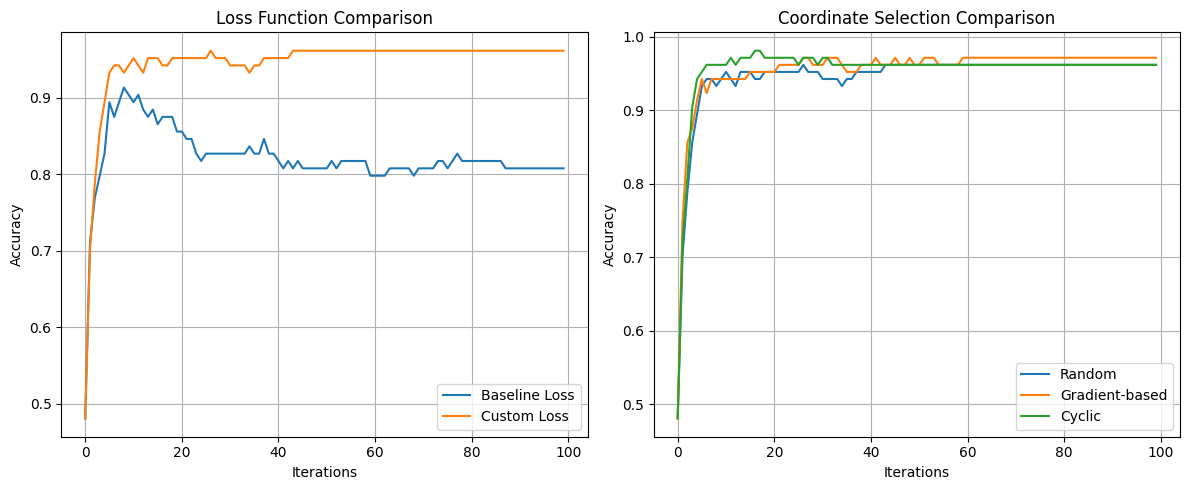

{'grid_search_results': {'best_params': {'lr': 0.01,
   'reg_lambda': 0.0,
   'max_iter': 1000},
  'best_score': np.float64(0.8938095238095236),
  'best_convergence': array([0.48075158, 0.48313253, 0.43978772, 0.521572  , 0.55527826,
         0.5624498 , 0.5551922 , 0.55757315, 0.6033276 , 0.62745267,
         0.65390132, 0.65149168, 0.64670109, 0.66589214, 0.67555938,
         0.67550201, 0.67791165, 0.68995984, 0.68273092, 0.69234079,
         0.70909352, 0.73075158, 0.74515204, 0.74759036, 0.74279977,
         0.75002869, 0.74520941, 0.76442915, 0.7788296 , 0.78846816,
         0.78364888, 0.7908778 , 0.79090648, 0.82208835, 0.81967871,
         0.82449799, 0.82211704, 0.83178428, 0.82455536, 0.81732645,
         0.82214573, 0.81973609, 0.82937464, 0.82699369, 0.82461274,
         0.84621343, 0.84856569, 0.83416523, 0.86061388, 0.87257602,
         0.86540448, 0.86781411, 0.87263339, 0.88221457, 0.87498566,
         0.88218589, 0.89420539, 0.89661503, 0.89420539, 0.89899598,
       

In [38]:
fullBreakdown(X, y, param_grid)

In [39]:
y_pred = best_model.predict(X_test)
accuracy = best_model.score(X_test, y_test)

# Evaluate performance
# accuracy = accuracy_score(y_test, y_pred)
print(f"Custom Baseline Logistic Regression Accuracy: {accuracy}")


Custom Baseline Logistic Regression Accuracy: 0.9230769230769231


In [ ]:
print(y_pred[:20])
print(y_test[:20].values)